## Setup

Import TensorFlow and other necessary libraries:

In [5]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

## Load data using a Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.
This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

In [7]:
data_dir = "../data/raw"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 60992 files belonging to 51 classes.
Using 48794 files for training.
Found 60992 files belonging to 51 classes.
Using 12198 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Black-grass', 'Blueberry___healthy', 'Charlock', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Fat Hen', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Loose Silky-bent', 'Maize', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Sugar beet', 'Tomato___Bacterial_spot', 'Tomato___

As the original dataset doesn't contain a test set, you will create one.
To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [10]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 245
Number of test batches: 61


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Transfer Learning approach

Create the base model from the pre-trained model MobileNetV2

In [7]:
# This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = MobileNetV2(input_shape=(180, 180, 3),
                         include_top=False,
                         weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze the base model
base_model.trainable = False

C:\Users\Bernd\AppData\Local\Temp\ipykernel_25780\3756985322.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(180, 180, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(32, 6, 6, 1280)


In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 90, 90,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 90, 90,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 90, 90,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 90, 90,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 90, 90,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 90, 90,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 91, 91,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 45, 45,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 45, 45,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Add a classification head
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = layers.Dense(len(class_names), activation='softmax')

In [10]:
# Build the model
inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
layer = preprocess_input(inputs)
layer = base_model(layer, training=False)
layer = global_average_layer(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
outputs = prediction_layer(layer)

model = tf.keras.Model(inputs, outputs)

## Compile the model

Compile the model before training it. Since there are many classes and a softmax oputput, use the `categorical_crossentropy`.

In [11]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [12]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

306/306 ━━━━━━━━━━━━━━━━━━━━ 161s 472ms/step - accuracy: 0.0185 - loss: 4.4292


In [13]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1, restore_best_weights = True)
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3, verbose = 1, cooldown = 5)

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks = [early_stopping, lr_plateau])

initial loss: 4.43
initial accuracy: 0.02
Epoch 1/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 909s 463ms/step - accuracy: 0.4431 - loss: 2.2233 - val_accuracy: 0.8409 - val_loss: 0.6397 - learning_rate: 1.0000e-04
Epoch 2/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 611s 401ms/step - accuracy: 0.8255 - loss: 0.6380 - val_accuracy: 0.8890 - val_loss: 0.4176 - learning_rate: 1.0000e-04
Epoch 3/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 608s 399ms/step - accuracy: 0.8755 - loss: 0.4363 - val_accuracy: 0.9097 - val_loss: 0.3323 - learning_rate: 1.0000e-04
Epoch 4/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 608s 399ms/step - accuracy: 0.8961 - loss: 0.3535 - val_accuracy: 0.9181 - val_loss: 0.2887 - learning_rate: 1.0000e-04
Epoch 5/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 603s 396ms/step - accuracy: 0.9108 - loss: 0.3005 - val_accuracy: 0.9260 - val_loss: 0.2573 - learning_rate: 1.0000e-04
Epoch 6/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 604s 396ms/step - accuracy: 0.9196 - loss: 0.2723 - val_accuracy: 0.9293 - val_loss: 0.2389 - learning_rat

## Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

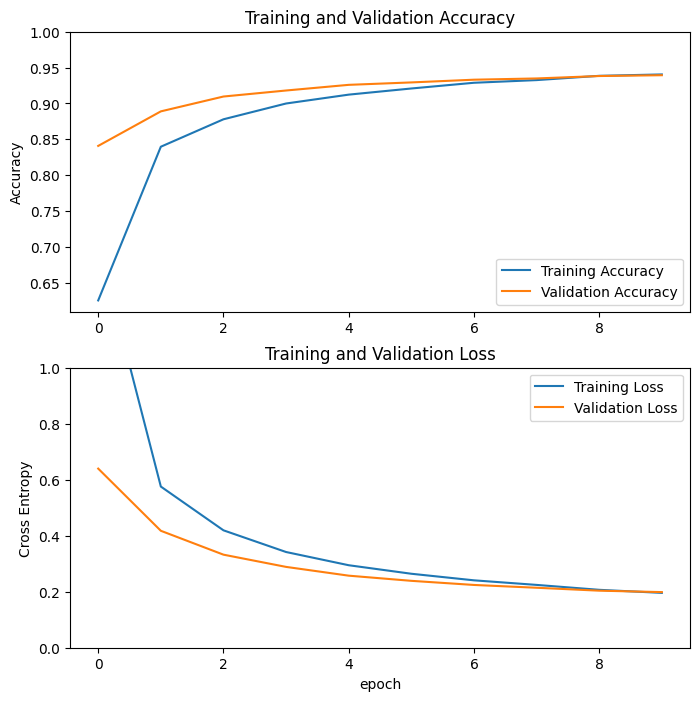

In [14]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

In [15]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


## Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [17]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds,
                         callbacks = [early_stopping, lr_plateau])

Epoch 11/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 899s 583ms/step - accuracy: 0.8955 - loss: 0.3599 - val_accuracy: 0.9262 - val_loss: 0.2401 - learning_rate: 1.0000e-04
Epoch 12/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 920s 603ms/step - accuracy: 0.9845 - loss: 0.0490 - val_accuracy: 0.9658 - val_loss: 0.1041 - learning_rate: 1.0000e-04
Epoch 13/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 889s 583ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9593 - val_loss: 0.1388 - learning_rate: 1.0000e-04
Epoch 14/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 901s 591ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9562 - val_loss: 0.1729 - learning_rate: 1.0000e-04
Epoch 15/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 902s 592ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9747 - val_loss: 0.0950 - learning_rate: 1.0000e-04
Epoch 16/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 1003s 658ms/step - accuracy: 0.9964 - loss: 0.0127 - val_accuracy: 0.9705 - val_loss: 0.1053 - learning_rate: 1.0000e-04
Epoch 17/20
1525/1525

In [19]:
# Saving the model
model.save("../lume_models.keras")

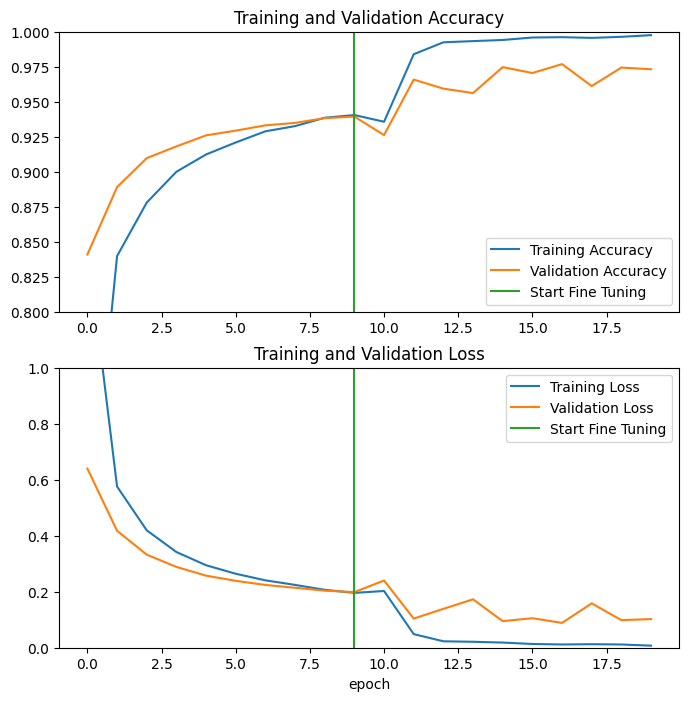

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [21]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 484ms/step - accuracy: 0.9720 - loss: 0.1015
Test accuracy : 0.9724506735801697


Predictions:
 [1 1 1 ... 1 1 1]
Labels:
 [27  3 24 48  7 18 25 16  1 36 20 24 41 24 41 11 43 48  3 43  2 40 38 21
 11 43 43 24 43 15 16 50]


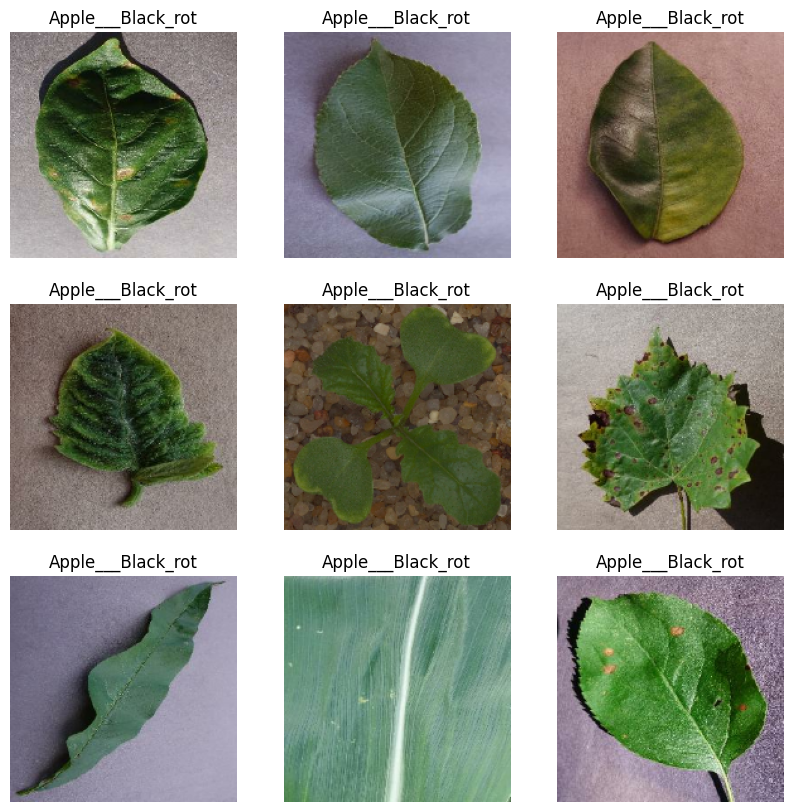

In [22]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [14]:
# Loading the model
model = tf.keras.models.load_model("../lume_models.keras")

c:\Users\Bernd\Documents\GitHub\apr24_bds_int_plant_recognition\venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 58 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


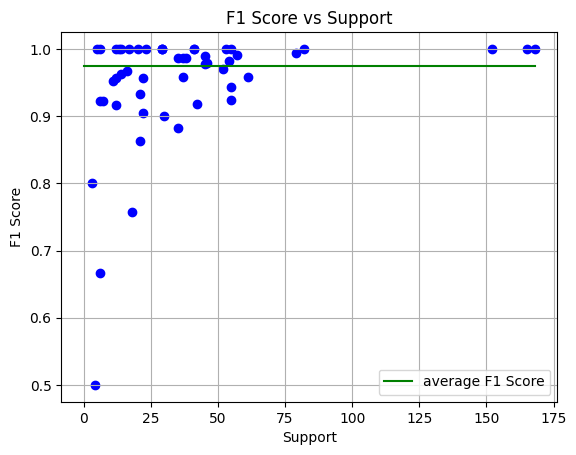

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Creating the predictions for the test_ds
predictions = np.array([])
labels =  np.array([])

for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x, verbose = False), axis = -1)]).astype(int)
  labels = np.concatenate([labels, y.numpy()]).astype(int)

# Creating a scatter plot on F1 score for the test-ds in relation to support, also add a line for the weighted average
precision, recall, fscore, support = precision_recall_fscore_support(labels, predictions)

f1score = classification_report(labels, predictions, output_dict=True)["weighted avg"]["f1-score"]

# Create the scatterplot
plt.scatter(support, fscore, marker='o', color='b')

plt.plot((0, support.max()), (f1score, f1score),
         label = 'average F1 Score',
         color = 'green')

plt.xlabel("Support")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Support")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
# Print the classification report, for this we "translate" the labels
c_true = np.array(class_names)[labels]
c_predict = np.array(class_names)[predictions]

print("Transfer Learning")
print(classification_report(c_true, c_predict))

Transfer Learning
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.92      1.00      0.96        22
                            Apple___Black_rot       1.00      0.93      0.96        14
                     Apple___Cedar_apple_rust       1.00      0.86      0.92         7
                              Apple___healthy       0.98      1.00      0.99        57
                    Background_without_leaves       1.00      1.00      1.00        29
                                  Black-grass       0.50      0.50      0.50         4
                          Blueberry___healthy       1.00      1.00      1.00        53
                                     Charlock       1.00      0.91      0.95        11
                      Cherry___Powdery_mildew       0.97      1.00      0.99        37
                             Cherry___healthy       1.00      1.00      1.00        23
                        